In [1]:
#Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
from sklearn.model_selection import train_test_split 
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import svm
import json
from pathlib import Path 
from sklearn.preprocessing import StandardScaler
from IPython.display import display
from datetime import datetime

# Business Understanding
1. What are the most important factors for a successful Airbnb listing?
2. How does location and time influence the price of my Airbnb?
3. Does the number of available listings influence the price?

In [2]:
df_listings = pd.read_csv('data/listings.csv')
df_calendar = pd.read_csv('data/calendar.csv')
print("There are %s listings in the listings.csv" % df_listings.shape[0])
print("There are %s entries in the calendar.csv" % df_calendar.shape[0])

There are 3818 listings in the listings.csv
There are 1393570 entries in the calendar.csv


In [3]:
def remove_dollar_sign(x):
    if (type(x) == str):
        x = x.replace('$','')
        x = x.replace(',','')
        return float(x)
    return (x)
def transform_percent(x):
    if (type(x) == str):
        x = x.replace('%','')
        return float(x)/100
    return (x)
def transform_boolean(x):
    if (type(x) == str):
        if (x == "f"): 
            return float(0)
        elif (x == "t"):
            return float(1)
def remove_zero_pad(x):
    if (type(x) == str):
        return int(x)
        
#def get_datetime_from_str(date_string)
    
def get_month(row):
    return int(row['date'].split('-')[1])

def get_year(row):
    return int(row['date'].split('-')[0])

fill_mean = lambda col: col.fillna(col.mean())

# Data Preparation

1. Convert to numerics
2. Convert f/t booleans to 0/1 booleans (numerics)
3. Enrich dataframe with amenities by introducing one additional column for every amentiy (categorical variable)
4. Resolve text columns to numerical values using the length of the values
5. Add categorical values neighbourhood_group_cleansed and property_type as indicator variables (both variables are never null)
6. Add new variable success_score to dataframe (as function from price, review_scores_rating, reviews_per_month)


In [ ]:
#1.) convert to numerics by removing dollar and percent
df_listings['price']=df_listings['price'].map(lambda x: remove_dollar_sign(x))
df_listings['weekly_price']=df_listings['weekly_price'].map(lambda x: remove_dollar_sign(x))
df_listings['monthly_price']=df_listings['monthly_price'].map(lambda x: remove_dollar_sign(x))
df_listings['security_deposit']=df_listings['security_deposit'].map(lambda x: remove_dollar_sign(x))
df_listings['host_response_rate']=df_listings['host_response_rate'].map(lambda x: transform_percent(x))
df_listings['host_acceptance_rate']=df_listings['host_acceptance_rate'].map(lambda x: transform_percent(x))

# convert 'string' booleans to 1/0 booleans
df_listings_booleans = df_listings[['host_is_superhost','instant_bookable','host_has_profile_pic']]
df_listings_booleans = df_listings_booleans.applymap(lambda x: transform_boolean(x))

df_listings_numeric_only = df_listings.select_dtypes(include=[np.number])
df_listings_numeric_only= df_listings_numeric_only.drop(['license','latitude','longitude','id','scrape_id','host_id'],axis=1)
df_listings_numeric_only = pd.concat([df_listings_numeric_only,df_listings_booleans], axis=1, join='inner')
# only numerics in dataframe => fill_mean to impute missing data
df_listings_numeric_only = df_listings_numeric_only.apply(fill_mean,axis=0)

# enrich dataframe with amenities
res = df_listings.amenities.apply(lambda s: s.replace('{','').replace('}','').replace('"',''))
amenities_set = set()
for elem in res:
    amenities_set.update(elem.split(','))
amenities_set=[x for x in amenities_set if x]
amenities_set.append('amenities_count')
dictionary = {key:list() for key in amenities_set}
for all_amenities in res:
    has_amenity = []
    for elem in all_amenities.split(','):
        if(elem):
            dictionary.setdefault(elem,[]).append(True)
        has_amenity.append(elem)
        
    dictionary.setdefault('amenities_count',[]).append(len(has_amenity))
    for key in dictionary.keys():
        if key not in has_amenity and key!='amenities_count':
            dictionary.get(key).append(False)

#resolve free text columns, length of entries might be interesting
text_length_columns = ['summary','space','description','name','notes','transit','neighborhood_overview']    
for column in text_length_columns:    
    for text_column_value in df_listings[column]:
        if text_column_value and not pd.isna(text_column_value):
            dictionary.setdefault("length_%s" % column,[]).append(len(text_column_value))
        else:
            dictionary.setdefault("length_%s" % column,[]).append(0)
    
df_amenities = pd.DataFrame(dictionary)
#create dataframe by concatenating the original dataframe 
df_listings_numeric_with_amentities = pd.concat([df_amenities, df_listings_numeric_only], axis=1, join='inner')

categorical_columns = ['neighbourhood_group_cleansed','property_type']       
df_categorical_values = pd.get_dummies(df_listings[categorical_columns],prefix_sep='_',drop_first=True, dummy_na=False)
df_listings_numeric_with_amentities=  pd.concat([df_listings_numeric_with_amentities, df_categorical_values], axis=1, join='inner')

Show that variables price, review_scores_rating and reviews_per_month that influence success_score are not correlated

,price,review_scores_rating,reviews_per_month
price,1.000000,0.050488,-0.199620
review_scores_rating,0.050488,1.000000,0.087062
reviews_per_month,-0.199620,0.087062,1.000000


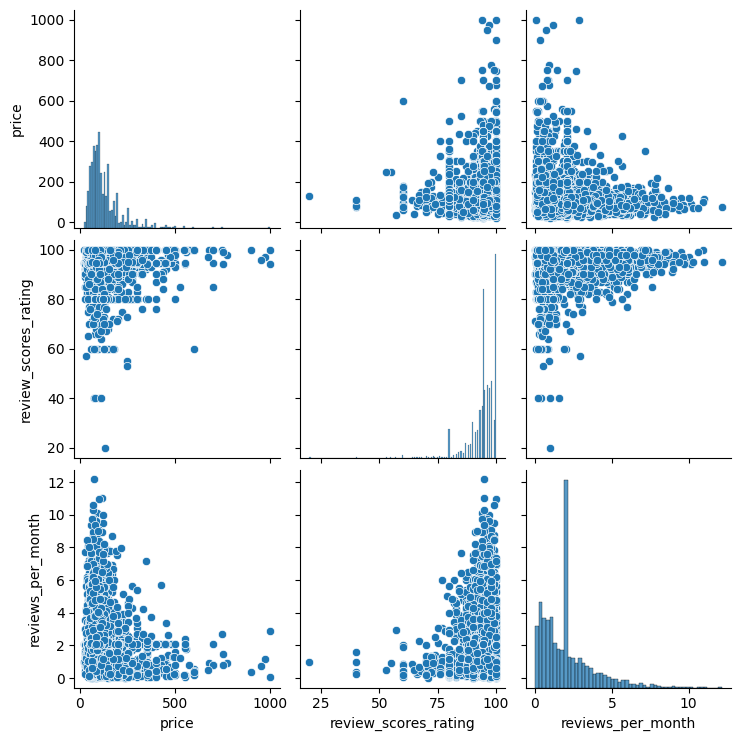

In [5]:
df_listings_numeric_with_amentities['success_score'] = df_listings_numeric_with_amentities['price']/100 * df_listings_numeric_with_amentities['review_scores_rating'] * df_listings_numeric_with_amentities['reviews_per_month']
sns.pairplot(df_listings_numeric_with_amentities[['price','review_scores_rating','reviews_per_month']])
df_listings_numeric_with_amentities[['price','review_scores_rating','reviews_per_month']].corr()

# Modeling and Visualization

In [6]:
def train_model_and_predict(data, prediction_param):
    '''
    This function trains a Linear Regression model on the given data and visualizes the results
    
    Parameters: 
    data (pandas.DataFrame) containing the data that should be used for training and testing the model
    prediction_param (string) name of the column in the dataframe that should be predicted
    '''
    y = data[prediction_param]
    try:
        X = data.drop([prediction_param],axis=1)
    except:
        print("param %s no longer in data" % (prediction_param))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=42)
    #important to standardize data, otherwise we cannot use the coefficients for reasoning about the importance of the different features
    sc_X = StandardScaler()
    X_train = sc_X.fit_transform(X_train)
    X_test = sc_X.transform(X_test)

    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train) 

    y_test_pred = lr_model.predict(X_test)
    y_train_pred = lr_model.predict(X_train)
    #residual plot
    plt.scatter(y_train_pred,  y_train_pred - y_train,c='blue', marker='o', label='Training data')
    plt.scatter(y_test_pred,  y_test_pred - y_test, c='lightgreen', marker='s', label='Test data')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.legend(loc='upper left')
    plt.show()
    # Result Evaluation
    print('Traning Data:')
    print('r2_score: %.3f' % r2_score(y_train, y_train_pred))
    print('---')
    print('Test Data:')
    print('r2_score: %.3f' % r2_score(y_test, y_test_pred))
    print('---')
    #analyze coefficients to determine most influental factors 
    cdf = pd.DataFrame(lr_model.coef_, X.columns, columns=['Coefficients'])
    sorted_coefficients = pd.concat([cdf.nlargest(15,'Coefficients'), cdf.nsmallest(15,'Coefficients')], axis=0)
    sorted_coefficients.sort_values(by='Coefficients').plot(kind="barh",xlabel='coefficient_value',ylabel='property')



# Q1: What are the most important factors for a successful Airbnb listing?

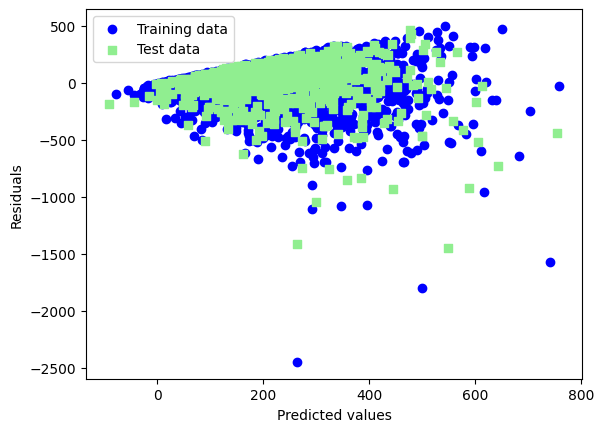

Traning Data:
r2_score: 0.289
---
Test Data:
r2_score: 0.290
---


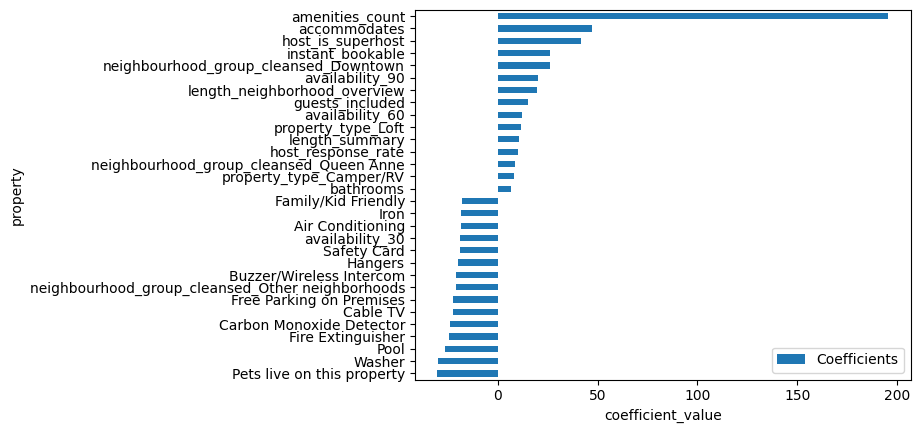

In [7]:

X = df_listings_numeric_with_amentities.drop(['square_feet','host_total_listings_count','price','reviews_per_month','weekly_price','monthly_price',
                                              'number_of_reviews','review_scores_accuracy','review_scores_location','review_scores_cleanliness','review_scores_checkin',
                                              'review_scores_communication','review_scores_value','review_scores_rating'],axis=1)
train_model_and_predict(X, 'success_score')
#

Even though with a relatively low r-squared score of 29% on the test data we cannot reliably use the model to predict our success it still explains 29% of the variance in the data!
#Furthermore the residual plot suggests a good enough model (https://www.qualtrics.com/support/stats-iq/analyses/regression-guides/interpreting-residual-plots-improve-regression/)

lets do a quick check of the correlation of success_score with all the other variables
=> big overlap between the set of variables with  highest coefficients and the ones with the biggest coeffiecients

In [8]:
print(X.corrwith(X['success_score']).sort_values(ascending=False))

success_score                                       1.000000
accommodates                                        0.285565
host_is_superhost                                   0.260969
beds                                                0.244699
guests_included                                     0.240075
amenities_count                                     0.192782
instant_bookable                                    0.189330
bedrooms                                            0.171762
length_neighborhood_overview                        0.162799
bathrooms                                           0.160279
neighbourhood_group_cleansed_Downtown               0.139007
host_response_rate                                  0.119330
length_transit                                      0.098594
length_summary                                      0.080015
length_description                                  0.079687
neighbourhood_group_cleansed_Queen Anne             0.074749
length_notes            

# Q2: How does location and time influence the price of my Airbnb?

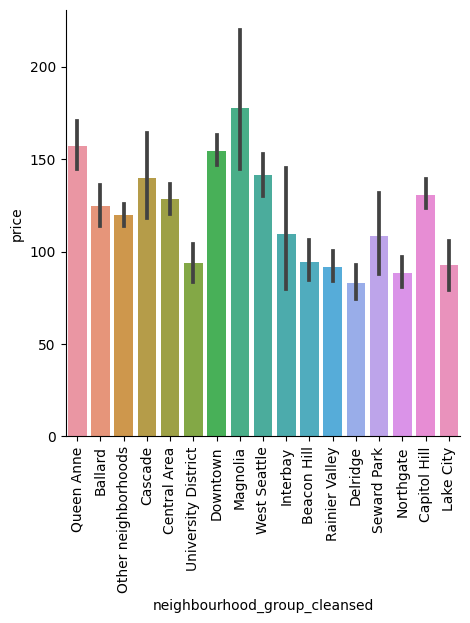

In [9]:
ax = sns.catplot(data=df_listings, x='neighbourhood_group_cleansed',y='price',kind="bar")
ax.set_xticklabels(rotation=90)

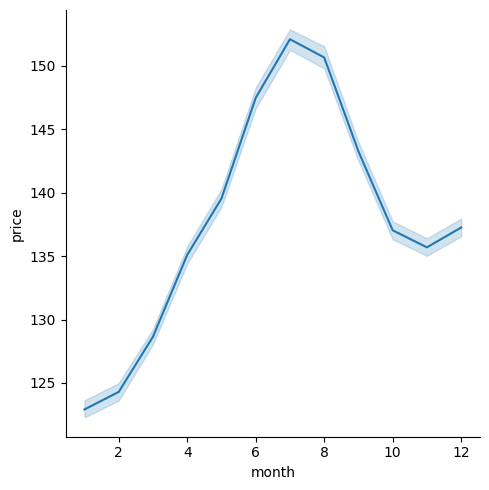

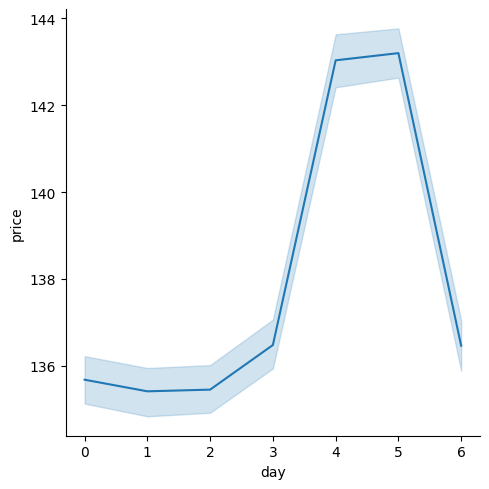

In [10]:
#Data Preparation
df_calendar['date'] = pd.to_datetime(df_calendar['date'],format="%Y-%m-%d")
df_calendar['year']= df_calendar['date'].dt.year
df_calendar['month']= df_calendar['date'].dt.month
df_calendar['day']= df_calendar['date'].dt.weekday
df_calendar['dayoftheyear']=df_calendar['date'].dt.strftime('%j')
df_calendar['price']=df_calendar['price'].map(lambda x: remove_dollar_sign(x))
df_calendar['dayoftheyear']=df_calendar['dayoftheyear'].map(lambda x: remove_zero_pad(x))
#drop columns where available is false
df_calendar_available= df_calendar[df_calendar.available == 't']
df_calendar_unavailable= df_calendar[df_calendar.available == 'f']

sns.relplot(data=df_calendar_available, x="month", y="price", kind="line")
sns.relplot(data=df_calendar_available, x="day", y="price", kind="line")

#relplot.set_xticklabels(rotation=90)
#its fairly easy to see in the summer June to August the listing prices are the highest
#furthermore it holds true that the prices


,dayoftheyear,sum,count,avg_price
0,1,403607.0,2922,138.126968
1,2,376350.0,2776,135.572767
2,4,211819.0,1735,122.085879
3,5,225312.0,1867,120.681307
4,6,220815.0,1826,120.928258


[0.33706756511892233, -0.17367142739013008, 0.0332748821258627, -0.14571514574466607, -0.07238514616138338, 0.0976338624135154, -0.3954034852204922, 0.0524399137366271, -0.613086225979384, -0.4008432687810011, 0.06132660957928985, 0.3597679689586354]


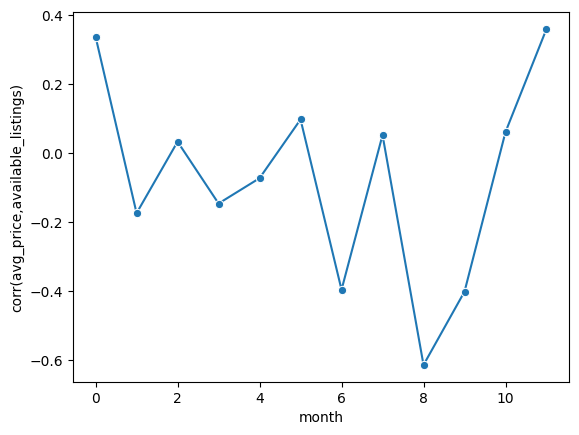

In [11]:
#3.) Does the number of available listings influence the price?
df_calendar_available_groupby_dayoftheyear= df_calendar_available.groupby('dayoftheyear')['price'].agg(['sum','count'])
df_calendar_available_groupby_dayoftheyear['avg_price'] = df_calendar_available_groupby_dayoftheyear['sum'].div(df_calendar_available_groupby_dayoftheyear['count'])
df_calendar_available_groupby_dayoftheyear.reset_index(inplace=True)
display(df_calendar_available_groupby_dayoftheyear.head())

last_check = 0
dfs = []
correlation_per_month = []
for x in range(1,13) :
    ind = x * 30
    dfs.append(df_calendar_available_groupby_dayoftheyear.loc[last_check:ind-1])
    last_check = ind
    correlation_per_month.append(dfs[x-1]['avg_price'].corr(dfs[x-1]['count']))
    #sns.regplot(x=dfs[x]["count"], y=dfs[x]["avg_price"])

fig = sns.lineplot(data=correlation_per_month, marker="o")
plt.xlabel("month")
plt.ylabel("corr(avg_price,available_listings)")
print(correlation_per_month)